# 1. Predicting Gender by First Name Using Character-level Machine Learning

*Please cite:*

Rego, R. C., Silva, V. M. & Fernandes, V. M. (2021). **Predicting Gender by First Name Using Character-level Machine Learning**. arXiv preprint arXiv:2106.10156 v2.




## 1.1 Necessary libraries

In [1]:
import pandas as pd                       
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, GRU, SimpleRNN, LSTM, Bidirectional, Activation, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


## 1.2 Download the dataset

In [2]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


### 1.2.1 Preparing the data 

In [3]:
y = df['classification'].astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
names = df['first_name'].apply(lambda x: x.lower())             # input names

In [8]:
print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

M : 45537
F : 55250
100787


## 1.3 Encoding Words

Neural networks can only learn to find patterns in numerical data, so it is necessary to convert our data into numeric values with word encoding or tokenization. 

In [10]:
#word encoding
maxlen = 20                                               # max lenght of a name

'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)

char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary
''' The dictionary maps each letter of vocabulary to a number '''

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

'''This is called one-hot-encoder and is based on the following papers: 
https://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names
https://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...
 '''

'This is called one-hot-encoder and is based on the following papers: \nhttps://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names\nhttps://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...\n '

In [11]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers 

## 1.4 Split the data into test and train

In [12]:
# train, val, test set will be 60%, 20%, 25% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=40)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

## 1.5 Building the BiLSTM Model

In [14]:
LSTMmodel = keras.Sequential()
LSTMmodel.add(Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Bidirectional(LSTM(64)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


LSTMhistory = LSTMmodel.fit(x_train, y_train, batch_size=128, epochs=20, validation_data =(x_val, y_val))
LSTMscores = LSTMmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (LSTMscores[1]*100))

Epoch 1/20
473/473 [==============================] - 65s 122ms/step - loss: 0.2730 - accuracy: 0.8924 - val_loss: 0.2197 - val_accuracy: 0.9271
Epoch 2/20
473/473 [==============================] - 56s 119ms/step - loss: 0.2014 - accuracy: 0.9330 - val_loss: 0.1933 - val_accuracy: 0.9384
Epoch 3/20
473/473 [==============================] - 56s 119ms/step - loss: 0.1798 - accuracy: 0.9444 - val_loss: 0.1884 - val_accuracy: 0.9400
Epoch 4/20
473/473 [==============================] - 56s 119ms/step - loss: 0.1639 - accuracy: 0.9512 - val_loss: 0.1693 - val_accuracy: 0.9485
Epoch 5/20
473/473 [==============================] - 56s 119ms/step - loss: 0.1537 - accuracy: 0.9561 - val_loss: 0.1653 - val_accuracy: 0.9493
Epoch 6/20
473/473 [==============================] - 56s 119ms/step - loss: 0.1426 - accuracy: 0.9607 - val_loss: 0.1623 - val_accuracy: 0.9502
Epoch 7/20
473/473 [==============================] - 57s 119ms/step - loss: 0.1359 - accuracy: 0.9644 - val_loss: 0.1566 - val_ac

## 1.7 Building the GRU Model

In [13]:
GRUmodel=keras.Sequential()
GRUmodel.add(GRU(32, input_shape=(x_train.shape[1],x_train.shape[2]),activation='tanh', return_sequences=True))
GRUmodel.add(TimeDistributed(Dense(1))) 
GRUmodel.add(Flatten())
GRUmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
GRUmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


GRUhistory=GRUmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
GRUscores = GRUmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (GRUscores[1]*100))  

Epoch 1/20
473/473 [==============================] - 10s 16ms/step - loss: 0.2557 - accuracy: 0.8854 - val_loss: 0.1979 - val_accuracy: 0.9230
Epoch 2/20
473/473 [==============================] - 7s 15ms/step - loss: 0.1691 - accuracy: 0.9339 - val_loss: 0.1652 - val_accuracy: 0.9358
Epoch 3/20
473/473 [==============================] - 7s 15ms/step - loss: 0.1478 - accuracy: 0.9438 - val_loss: 0.1586 - val_accuracy: 0.9413
Epoch 4/20
473/473 [==============================] - 7s 15ms/step - loss: 0.1376 - accuracy: 0.9473 - val_loss: 0.1509 - val_accuracy: 0.9441
Epoch 5/20
473/473 [==============================] - 7s 15ms/step - loss: 0.1270 - accuracy: 0.9511 - val_loss: 0.1477 - val_accuracy: 0.9455
Epoch 6/20
473/473 [==============================] - 7s 15ms/step - loss: 0.1176 - accuracy: 0.9563 - val_loss: 0.1439 - val_accuracy: 0.9480
Epoch 7/20
473/473 [==============================] - 7s 15ms/step - loss: 0.1123 - accuracy: 0.9570 - val_loss: 0.1409 - val_accuracy: 0.946

## 1.10 Figures

<Figure size 432x288 with 0 Axes>

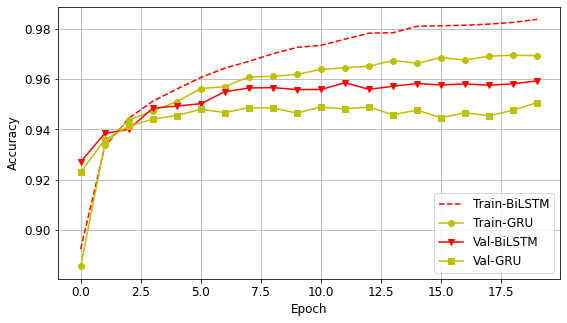

In [18]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(LSTMhistory.history['accuracy'], 'r--')
plt.plot(GRUhistory.history['accuracy'], 'y-o')
plt.plot(LSTMhistory.history['val_accuracy'], 'r-v')
plt.plot(GRUhistory.history['val_accuracy'], 'y-s')
#plt.xscale('log')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.ylim(0.8, 0.99)
#plt.xlim(0,25)
plt.legend(['Train-BiLSTM', 'Train-GRU', 'Val-BiLSTM', 'Val-GRU'], loc='lower right')
#plt.gcf().savefig('accuracy.eps', format='eps', dpi=600)     # save the figure

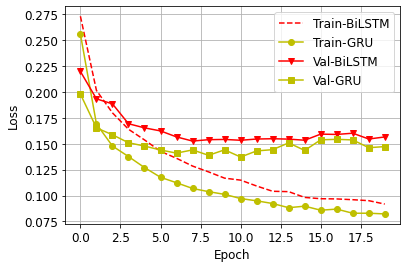

In [20]:
plt.figure(2)
# summarize for loss
plt.plot(LSTMhistory.history['loss'], 'r--')
plt.plot(GRUhistory.history['loss'], 'y-o')
plt.plot(LSTMhistory.history['val_loss'], 'r-v')
plt.plot(GRUhistory.history['val_loss'], 'y-s')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-BiLSTM','Train-GRU','Val-BiLSTM', 'Val-GRU'], loc='upper right')
#plt.yscale('log')
#plt.xscale('log')
plt.grid('True')
#plt.xlim(0,32)
#plt.gcf().savefig('loss.eps', format='eps', dpi=600)     # save the figure

## 1.11 Statistics

In [21]:
y_predLSTM =(LSTMmodel.predict(x_test) > 0.5).astype("int32")
y_predGRU =(GRUmodel.predict(x_test) > 0.5).astype("int32")

In [22]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, y_predLSTM))
print(recall_score(y_test, y_predLSTM))
print(precision_score(y_test, y_predGRU))
print(recall_score(y_test, y_predGRU))

0.9575596816976127
0.9516695957820738
0.9417666303162486
0.9485940246045694


## 1.12 Testing 

In [23]:
testename = prepare_encod_names({"cibely"})   # Now the names are encod as a vector of numbers with weight
resu=(LSTMmodel.predict(testename) > 0.5).astype("int32")
if int(resu)==1:
  print('M')
else:
  print('F')

F
